/Users/matsen/re/sci-space-v2/ssv2/simulation.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beads_near_center_df["decay"] = beads_near_center_df["dist_from_center"].apply(
/Users/matsen/re/sci-space-v2/ssv2/simulation.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beads_near_center_df["x_displacement"] = (
/Users/matsen/re/sci-space-v2/ssv2/simulation.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

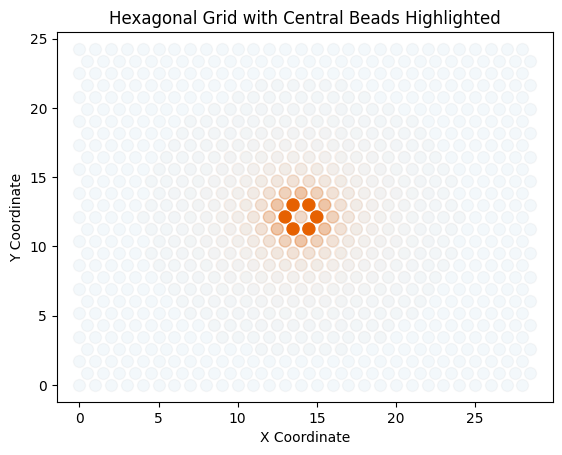

In [9]:
import pandas as pd
import numpy as np

from ssv2.simulation import BaseSimulation


simulator = BaseSimulation(29, 29)

simulator.plot_setting()


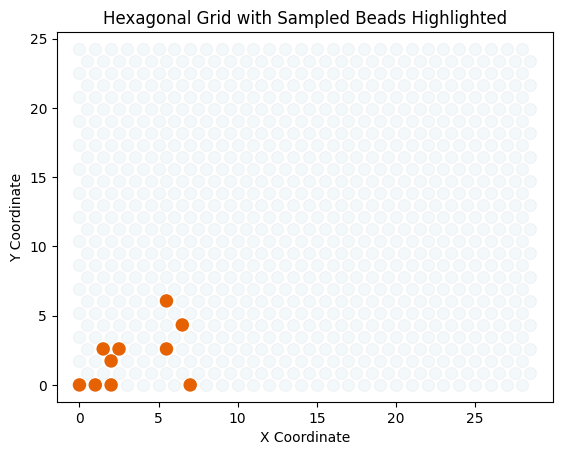

       x_coord  y_coord  bead_counts
index                               
0.0        0.0    0.000            1
1.0        1.0    0.000            1
2.0        2.0    0.000            1
7.0        7.0    0.000            1
60.0       2.0    1.732            1
88.0       1.5    2.598            1
89.0       2.5    2.598            1
92.0       5.5    2.598            1
151.0      6.5    4.330            1
NaN        5.5    6.063            1


In [10]:
simulator.plot_sample(20, 0)